# Predicting Age from X-Rays with Deep Learning
After finishing the great kaggle course [Deep Learning](https://www.kaggle.com/learn/deep-learning), I'm trying to get some practice with this dataset.
## Setup

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['boneage-training-dataset.csv', 'boneage-test-dataset.csv', 'boneage-test-dataset', 'boneage-training-dataset']


## Preview the data

In [2]:
train_df = pd.read_csv("../input/boneage-training-dataset.csv")
train_df.shape

(12611, 3)

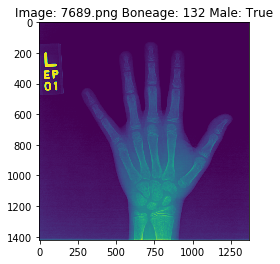

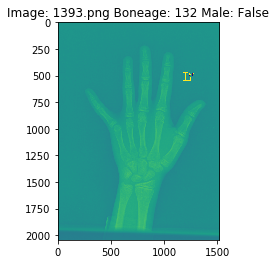

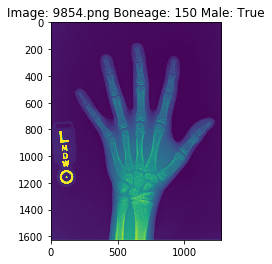

In [3]:
#print(os.listdir("../input/boneage-training-dataset/boneage-training-dataset"))
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for img_id, boneage, male in train_df[['id','boneage','male']].sample(3).values:
    img_name = str(img_id) + '.png'
    img = mpimg.imread("../input/boneage-training-dataset/boneage-training-dataset/"+img_name)
    plt.imshow(img)
    plt.title('Image: {} Boneage: {} Male: {}'.format(img_name, boneage, male))
    plt.show()

## Function for preparing images taken from the [deep learning course of DanB](https://www.kaggle.com/dansbecker/tensorflow-programming)

In [4]:
import numpy as np
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

def read_and_prep_images(img_paths, img_height, img_width, color_mode="grayscale"):
    imgs = [load_img(img_path, target_size=(img_height, img_width), color_mode=color_mode) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    #output = preprocess_input(img_array)
    return(img_array)

## Creating the Model
I want to do regression instead of classification, so I have to do some changes compared to the deep learning method.

### Initial model

In [5]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D

# quadratic approach
quadratic = True
image_size = 128

# some kind of ratio if not quadratic approach
img_rows = image_size if quadratic else 144 
img_cols = image_size if quadratic else 114

initial_model = Sequential()

# Input Layer
initial_model.add(Conv2D(12, kernel_size=(4,4), activation='relu', input_shape=(img_rows, img_cols, 1)))


# Convulotional Layers
initial_model.add(Conv2D(20, kernel_size=(4,4), activation='relu'))
initial_model.add(Conv2D(20, kernel_size=(3,3), activation='relu'))

# Flattening
initial_model.add(Flatten())

# Dense Layer
initial_model.add(Dense(100))
initial_model.add(Dense(1))

initial_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

### New model
Not so new anymore... but had the best results so far.

In [6]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout

boner_model = Sequential()

# Input Layer
boner_model.add(Conv2D(16, kernel_size=(7,7), strides=(2,2), activation='relu', input_shape=(img_rows, img_cols, 3)))
boner_model.add(Dropout(0.25))

# Convulotional Layers
boner_model.add(Conv2D(32, kernel_size=(5,5), strides=(2,2), activation='relu'))
boner_model.add(Dropout(0.25))
boner_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
#boner_model.add(Dropout(0.25))
boner_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
boner_model.add(Dropout(0.25))

# Flattening
boner_model.add(Flatten())

# Dense Layer
boner_model.add(Dense(256, activation='relu'))
#boner_model.add(Dropout(0.25))
boner_model.add(Dense(1))

boner_model.compile(loss='mean_squared_error', optimizer='adam')

Thanks to Vijayabhaskar I was able to combine augmentation with sequential loading data into memry. See his [blog post](https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1)

In [7]:
from keras.preprocessing.image import ImageDataGenerator


train_df['imagepath'] = [f'{pid}.png' for pid in train_df.id]
#Lazy way of creating training and test set.
train = train_df.head(10000)
test = train_df.tail(2600)


datagen=ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.15,
                           width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                           horizontal_flip=True, fill_mode="nearest")
train_generator=datagen.flow_from_dataframe(dataframe=train, 
                                            directory="../input/boneage-training-dataset/boneage-training-dataset/", 
                                            x_col="imagepath", 
                                            y_col="boneage", 
                                            class_mode="other", 
                                            target_size=(img_rows,img_cols), 
                                            batch_size=32)

valid_generator=datagen.flow_from_dataframe(dataframe=test, 
                                            directory="../input/boneage-training-dataset/boneage-training-dataset/", 
                                            x_col="imagepath", 
                                            y_col="boneage", 
                                            class_mode="other", 
                                            target_size=(img_rows,img_cols), 
                                            batch_size=32)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
history = boner_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50)

Using TensorFlow backend.


Found 10000 validated image filenames.
Found 2600 validated image filenames.
Epoch 1/50
313/313 [==============================] - 520s 2s/step - loss: 2869.1066 - val_loss: 1503.6136
Epoch 2/50
313/313 [==============================] - 436s 1s/step - loss: 1761.7185 - val_loss: 1445.5599
Epoch 3/50
313/313 [==============================] - 435s 1s/step - loss: 1668.8274 - val_loss: 1347.4917
Epoch 4/50
313/313 [==============================] - 439s 1s/step - loss: 1617.2782 - val_loss: 1639.2211
Epoch 5/50
313/313 [==============================] - 453s 1s/step - loss: 1563.5718 - val_loss: 1307.1713
Epoch 6/50
313/313 [==============================] - 432s 1s/step - loss: 1559.9772 - val_loss: 1575.0493
Epoch 7/50
313/313 [==============================] - 428s 1s/step - loss: 1554.2081 - val_loss: 1252.4191
Epoch 8/50
313/313 [==============================] - 444s 1s/step - loss: 1501.1772 - val_loss: 1373.6347
Epoch 9/50
313/313 [==============================] - 440s 1s/step 

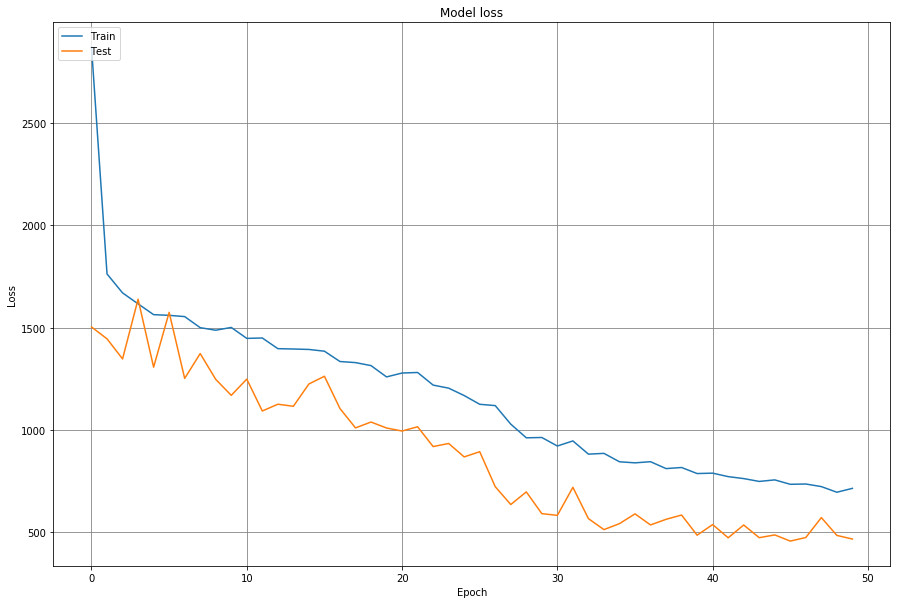

In [8]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
f, ax = plt.subplots(1,1, figsize=(15,10))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
ax.grid(color='grey')
plt.show()

# Visualizing the Filters of my CNN
Based on this great blog post https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030 I want to see what patterns the filters of my CNN are looking for.

Ran into several problems. My model is TF/Keras and the blogs code is in Torch/fastai. Came up with a really messed up way to run the code but the image still look like blurred random images. Trying to figure out how to move on.

I could recreate the model in Torch and try it with the code as found on the blog. Or I could try to dig deeper.

Lets see what I will do next time... 


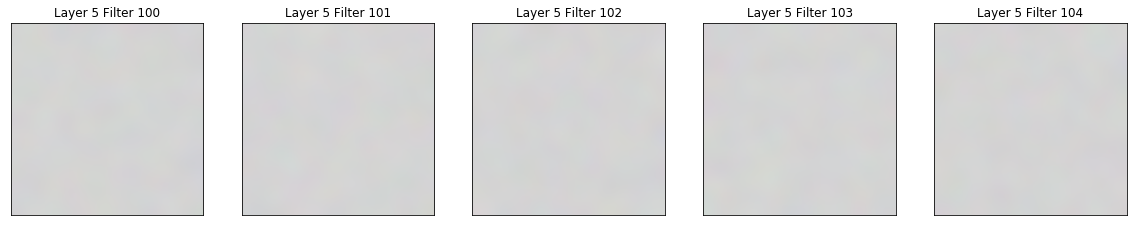

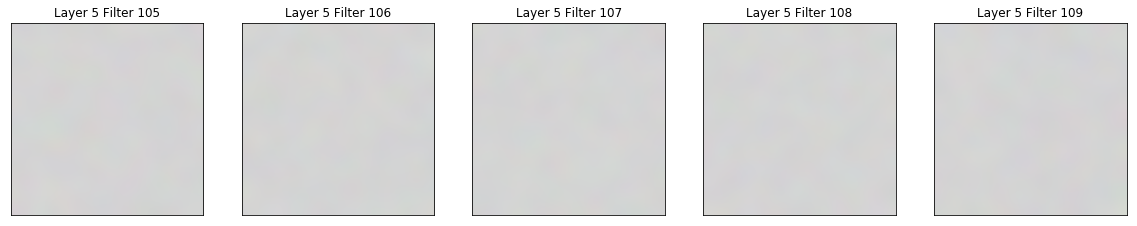

In [9]:
from tensorflow.keras import models
import torch
import cv2

layer_level = 5
filter = 3

def mygawd(layer_level, filter):
    opt_steps = 100
    upscaling_steps = 12
    upscaling_factor = 1.2
    blur = 5
    sz = 56
    
    img = np.uint8(np.random.uniform(150, 180, (sz, sz, 3)))/255


    layer_outputs = [layer.output for layer in boner_model.layers] # Extracts the outputs of the top layers
    activation_model = models.Model(inputs=boner_model.input, outputs=layer_outputs[layer_level]) # Creates a model that will return these outputs, given the model input
    activation_model.trainable = False
    
    img_var = torch.tensor(np.array([img]),requires_grad=True)
    #print(f'img_var.mean() before: {img_var.mean()}')
    for _ in range(upscaling_steps):  # scale the image up upscaling_steps times
        optimizer = torch.optim.Adam([img_var], lr=0.1, weight_decay=1e-6)
        #print('peng')
        for n in range(opt_steps):  # optimize pixel values for opt_steps times
            #optimizer.zero_grad()
            # Ugly way to get the data out of the variable and make it posssible to send it to the model
            temp = img_var[:,:,:,:].detach().numpy()
            feature_map = activation_model.predict(cv2.resize(temp.reshape((sz,sz,3)), (128, 128)).reshape((1,128,128,3)))
            activation =torch.tensor(feature_map[0,:,:,filter],requires_grad=True)
            loss = -activation.mean()
            #print(f'loss: {loss}')
            loss.backward()
            # Couldn't figure out another way to update the pixels of img_var... probably won't work... sigh
            img_var.backward(gradient=torch.ones([1, sz, sz, 3], dtype=torch.float64) * activation.grad.mean())
            optimizer.step()
        sz = int(upscaling_factor * sz)  # calculate new image size
        img = img_var.data.cpu().numpy()[0]
        img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
        if blur is not None: img = cv2.blur(img,(blur,blur)) # blur image to reduce high frequency patterns
        img_var = torch.tensor(np.array([img]),requires_grad=True)
    #print(f'img_var.mean() after: {img_var.mean()}')
    #print(f'activation.shape: {activation.shape}')
    #fig, ax = plt.subplots()
    #ax.imshow((img_var[0,:,:,].detach().numpy()* 255).astype(np.uint8))
    #ax.set_title(f'Layer {layer_level} Filter {filter}')
    #plt.axis('off')
    return (img_var[0,:,:,].detach().numpy()* 255).astype(np.uint8)

for i, filter in enumerate(range(100,110)):
    # Ad new row if row is full
    if i%5 == 0:
        fig, axes = plt.subplots(1,5, figsize=(20,5))
    filter_img = mygawd(layer_level, filter)
    axes[i%5].imshow(filter_img)
    at = axes[i%5].set_title(f'Layer {layer_level} Filter {filter}')
    at = axes[i%5].set_xticks([])
    at = axes[i%5].set_yticks([])